In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import PIL
import read_datasets as rd
import constants as CONST
from importlib import reload

reload(CONST)
import base64
import pickle
import collections
import itertools, collections
from sklearn.metrics import mean_squared_error
import cv2 
import math

In [2]:
reload(rd)

<module 'read_datasets' from '/home/xiaoyuz1/amazon_turk/read_datasets.py'>

In [3]:
import torch.nn.utils.rnn as rnn
import torch

In [4]:
np.set_printoptions(precision=4, suppress=True)

In [5]:
dfo = pd.read_csv('/raid/xiaoyuz1/amazon_turk/df_all.csv')
dfo['no_punc_1'] = dfo.no_punc_1.apply(lambda x: [str(y).strip()[1:-1] for y in x[1:-1].split(',')])

dfp = pd.read_csv('/raid/xiaoyuz1/amazon_turk/df_all_pair.csv')
dfp['no_punc_1'] = dfp.no_punc_1.apply(lambda x: [str(y).strip()[1:-1] for y in x[1:-1].split(',')])
dfp['no_punc_2'] = dfp.no_punc_2.apply(lambda x: [str(y).strip()[1:-1] for y in x[1:-1].split(',')])

## use pretrained word features

In [ ]:
import clip
device = "cuda"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False) #Must set jit=False for training

In [ ]:
root_folder = '/raid/xiaoyuz1/clip_model_checkpoint'
torch_path_name = os.path.join(root_folder, "pleasant-tree-10.pt")
checkpoint = torch.load(torch_path_name)
print(checkpoint.keys())
args = checkpoint['args']

model.load_state_dict(checkpoint['model_state_dict'])

## testing out sketch-rnn

In [ ]:
import sys 
sys.path.insert(0, '/home/xiaoyuz1/amazon_turk/Pytorch-Sketch-RNN')

In [ ]:
import sketch_rnn
reload(sketch_rnn)
from sketch_rnn import *

In [ ]:
# sketch_dataset = np.load(hp.data_location, encoding='latin1', allow_pickle=True)
# sketch_data = sketch_dataset['train']
# print(sketch_data.shape)
# sketch_data, kept_idx = purify(sketch_data)
# scale_factor = calculate_normalizing_scale_factor(sketch_data)
# sketch_data = normalize(sketch_data)
# Nmax = max_size(sketch_data)

In [ ]:
model = Model()

In [ ]:
batch, lengths = make_batch(hp.batch_size)

In [ ]:
mask, dx, dy, p = model.make_target(batch, lengths)

In [ ]:
print(mask.shape)

In [ ]:
z, mu, sigma = model.encoder(batch, hp.batch_size)
sos = torch.stack([torch.Tensor([0,0,1,0,0])]*hp.batch_size).cuda().unsqueeze(0)

In [ ]:
batch_init = torch.cat([sos, batch], 0)
z_stack = torch.stack([z] * (Nmax + 1)) 
inputs = torch.cat([batch_init, z_stack], 2) 
print(inputs.shape)

In [ ]:
pi,mu_x,mu_y,sigma_x,sigma_y,rho_xy,q,_,_ = model.decoder(inputs, z) 

In [ ]:
model.pi = pi
model.mu_x = mu_x
model.mu_y = mu_y
model.sigma_x = sigma_x
model.sigma_y = sigma_y
model.rho_xy = rho_xy
model.q = q

In [ ]:
pdf = model.bivariate_normal_pdf(dx, dy)

In [ ]:
print(pi.shape, mu_x.shape, mu_y.shape, sigma_x.shape, sigma_y.shape, rho_xy.shape, q.shape)

In [ ]:
class HParams():
    def __init__(self):
        self.word_embed_dim = 128
        self.lstm_output_dim = 512
        self.lstm_layers = 2 
        self.lstm_drop_prob = 0.4
        self.num_primitives = 6
        self.num_transformation_params = 6
        self.vocab_size = None
        self.M = 2
        self.weight_decay = 0.0
        self.start_epoch = 0
        self.num_epochs = 50
        self.wandb_enabled = False 
        self.wandb_project_name = "doodler-draw"
        self.wandb_project_entity="erinz"

In [ ]:
hp = HParams()

In [ ]:
hp.__dict__

In [ ]:
import torch
from torch import LongTensor
from torch.nn import Embedding, LSTM
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# We want to run LSTM on a batch following 3 character sequences
seqs = ['long_str',  # len = 8
        'tiny',      # len = 4
        'medium']    # len = 6

vocab = ['<pad>'] + sorted(set([char for seq in seqs for char in seq]))
vectorized_seqs = [[vocab.index(tok) for tok in seq]for seq in seqs]
##--------------------##
embed = Embedding(len(vocab), 4) # embedding_dim = 4
lstm = LSTM(input_size=4, hidden_size=5, batch_first=True) # input_dim = 4, hidden_dim = 5
seq_lengths = LongTensor(list(map(len, vectorized_seqs)))
seq_tensor = Variable(torch.zeros((len(vectorized_seqs), seq_lengths.max()))).long()

for idx, (seq, seqlen) in enumerate(zip(vectorized_seqs, seq_lengths)):
    seq_tensor[idx, :seqlen] = LongTensor(seq)

seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
seq_tensor = seq_tensor[perm_idx]

embedded_seq_tensor = embed(seq_tensor)
packed_input = pack_padded_sequence(embedded_seq_tensor, seq_lengths.cpu().numpy(), batch_first=True)
packed_output, (ht, ct) = lstm(packed_input)
output, input_sizes = pad_packed_sequence(packed_output, batch_first=True)

In [ ]:
output.shape

In [ ]:
ht[-1]

## fitting primitives

In [6]:
reload(rd)

<module 'read_datasets' from '/home/xiaoyuz1/amazon_turk/read_datasets.py'>

In [7]:
w = h = 256
TEMPLATE_DICT = {
    'arc' : lambda n : rd.generate_arc(n1=n, radius=1, x0=0, y0=0, template_size=1),
    'circle' : lambda n : rd.generate_circle(n1=n, radius=1, x0=0, y0=0, template_size=1),
    'square' : lambda n : rd.generate_square(n1=n, template_size=2),
    'semicircle' : lambda n : rd.generate_semicircle(n1=n, radius=1, x0=0, y0=0, template_size=w),
    'zigzag1' : lambda n : rd.generate_zigzag(n1=n, num_fold=1, side_length=1,template_size=1),
}

In [8]:
b_spline_num_sampled_points = num_sampled_points = n = 200
use_projective = False

In [27]:
templates = {}
template_dict_processed = {}
for i,(k,v) in enumerate(TEMPLATE_DICT.items()):
    arr = v(b_spline_num_sampled_points)
    template_dict_processed[k] = arr
    templates[i] = (k,arr)

In [ ]:
rd.plot_primitives(template_dict_processed,w=2, h=2,num_pngs_per_row = 1, row_figsize = 10, column_figsize = 10)

In [11]:
import primitive_selector as ps
reload(ps)
all_data = ps.prepare_data(dfo, templates, num_sampled_points = 200, use_projective = False)

100%|██████████| 11150/11150 [00:31<00:00, 350.64it/s]


In [12]:
with open("/raid/xiaoyuz1/primitive_selector_training_data/july_15_all.pkl", "wb+") as f:
    pickle.dump(all_data, f)

In [13]:
for t in ["train", "dev", "test"]:
    data_split = [x for x in all_data if x["split"] == t]
    data_split_dict = dict(zip(range(len(data_split)), data_split))
    with open(f"/raid/xiaoyuz1/primitive_selector_training_data/july_15_{t}.pkl", "wb+") as f:
        pickle.dump(data_split, f)

In [30]:
all_data = pickle.load(open("/raid/xiaoyuz1/primitive_selector_training_data/july_15_all.pkl", "rb"))
df = pd.DataFrame(all_data)

In [31]:
df

,category,image_idx,part,raw,processed,primitive_type,M,error,split,theta,sx,sy,hx,tx,ty
0,face,722,0,linear eyes,linear eyes,1,"[36.85612131004554, -10.970504821069582, 132.7...",37.444571,train,0.224263,37.802771,16.159025,-0.200155,132.785595,74.027565
1,face,260,0,open oval eyes,open oval eyes,3,"[49.41083595822099, 4.254886014940929, 130.076...",22.838999,train,-0.015050,49.416432,24.651618,0.078604,130.076608,71.973470
2,face,556,1,small curved nose,small curved nose,4,"[-2.3064865124396228, -10.508444066574171, 123...",4.642066,train,1.662260,25.252579,10.440874,0.048217,123.797884,137.960813
3,face,144,1,large curved nose,large curved nose,0,"[-0.49812495599203443, -30.69292589292542, 118...",1.179808,train,-1.591851,23.660009,-30.782180,-0.165484,118.245320,136.877089
4,face,419,2,wide u-shaped mouth,wide u mouth,0,"[-68.96632993158389, 8.529678357038451, 164.00...",269.367030,train,3.119171,68.983669,-26.192552,-0.115164,164.009220,156.407727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11145,angel,280,5,serrated body,serrate body,2,"[6.203409443124921, 35.50957934201021, 118.944...",357.276043,test,-1.443752,48.960319,37.435880,-0.261887,118.944754,148.646961
11146,angel,736,7,butterfly-shaped wings,butterfly wings,1,"[-87.93183202073655, 19.80444591125769, 122.04...",148.743023,dev,-2.997649,88.850724,57.656463,-0.131168,122.047780,149.441755
11147,angel,477,7,bumpy wings,bumpy wings,1,"[-86.79657055920823, -19.99634998966547, 120.8...",241.182669,train,2.835990,91.013612,39.340219,0.094015,120.801940,132.962412
11148,angel,614,4,rectangular face,rectangular face,1,"[-26.229255868114652, -7.147026401576246, 115....",31.336491,train,2.946416,26.736898,24.249871,0.093179,115.636372,71.639109


In [14]:
for t in ["train", "dev", "test"]:
    all_data = pickle.load(open(f"/raid/xiaoyuz1/primitive_selector_training_data/july_15_{t}.pkl", "rb"))    
    all_sequences = []
    for info in all_data:
        if info['category'] == 'face':
            drawing_raw = CONST.face_json['train_data'][info['image_idx']]
            part_indices = list(CONST.face_parts_idx_dict_doodler.keys())
        else:
            drawing_raw = CONST.angel_json['train_data'][info['image_idx']]
            part_indices = list(CONST.angel_parts_idx_dict_doodler.keys())

        parts = rd.process_quickdraw_to_part_convex_hull(
            drawing_raw,
            part_indices,
            b_spline_num_sampled_points=num_sampled_points,
        )
        data = parts[info['part']]
        template = templates[info['primitive_type']][1]
        transform_mat = np.asarray(info['M']).astype(float).reshape(3,3)

        if use_projective:
            result = cv2.perspectiveTransform(template, transform_mat).reshape(-1,2)
        else:
            result = cv2.transform(np.array([template]).astype(
                np.float32), transform_mat)[0][:,:-1]

        all_sequences.append([data, template, result])
    
    with open(f"/raid/xiaoyuz1/primitive_selector_training_data/july_15_{t}_sequences.pkl", "wb+") as f:
        pickle.dump(all_sequences, f)

In [ ]:
data,template,result = all_sequences[100]

fig, axs = plt.subplots(2, 1, figsize=(12,24)) 
axs[0].scatter(data[:,0], data[:,1], s=1, c='g')
axs[0].scatter(result[:,0], result[:,1], s=1, c='r')
axs[0].scatter(template[:,0], template[:,1], s=1, c='b')

axs[0].axis(xmin=-w,xmax=w)
axs[0].axis(ymin=h,ymax=-h)

plt.show()

In [34]:
def plot_prepared_data(info, num_sampled_points = 200, use_projective=False):
    fig, axs = plt.subplots(2, 1, figsize=(12,24)) 
    if info['category'] == 'face':
        drawing_raw = CONST.face_json['train_data'][info['image_idx']]
        part_indices = list(CONST.face_parts_idx_dict_doodler.keys())
    else:
        drawing_raw = CONST.angel_json['train_data'][info['image_idx']]
        part_indices = list(CONST.angel_parts_idx_dict_doodler.keys())

    parts = rd.process_quickdraw_to_part_convex_hull(
        drawing_raw,
        part_indices,
        b_spline_num_sampled_points=num_sampled_points,
    )
    data = parts[info['part']]
    template = templates[info['primitive_type']][1]
    transform_mat = np.asarray(info['M']).astype(float).reshape(3,3)
#     axs[0].scatter(template[:,0], template[:,1], s=1, c='b')
    
    if use_projective:
        result = cv2.perspectiveTransform(template, transform_mat).reshape(-1,2)
    else:
        result = cv2.transform(np.array([template]).astype(
            np.float32), transform_mat)[0][:,:-1]
    
    
    axs[0].scatter(result[:,0], result[:,1], s=1, c='r')
    
#     theta, scale_mat, shear_mat = rd.decompose_affine(transform_mat)
#     T_rotate = rd.get_rotation_matrix(theta)
#     T_scale = rd.get_scale_matrix(scale_mat[0][0], scale_mat[1][1])
#     T_shear = rd.get_shear_matrix(shear_mat[0][1], shear_mat[1][0])
#     tx,ty = transform_mat[0][2],transform_mat[1][2]
#     T_translate = rd.get_translation_matrix(tx,ty)
    
#     result1 = cv2.transform(np.array([template]).astype(
#             np.float32), T_rotate)[0][:,:-1]
#     axs[0].scatter(result1[:,0], result1[:,1], s=1, c='m')
    
#     result2 = cv2.transform(np.array([template]).astype(
#             np.float32), T_rotate @ T_scale @ T_shear)[0][:,:-1]
#     axs[0].scatter(result2[:,0], result2[:,1], s=1, alpha=0.5, c='pink')

#     result3 = cv2.transform(np.array([template]).astype(
#             np.float32), T_translate @ T_rotate @ T_scale @ T_shear)[0][:,:-1]
#     axs[0].scatter(result3[:,0], result3[:,1], s=1, c='lime', alpha=0.5)
    
    axs[0].scatter(data[:,0], data[:,1], alpha=0.5, s=1, c='lime')

    axs[0].axis(xmin=-w,xmax=w)
    axs[0].axis(ymin=h,ymax=-h)
    axs[1].axis(xmin=-w,xmax=w)
    axs[1].axis(ymin=h,ymax=-h)

    
    
    plt.show()

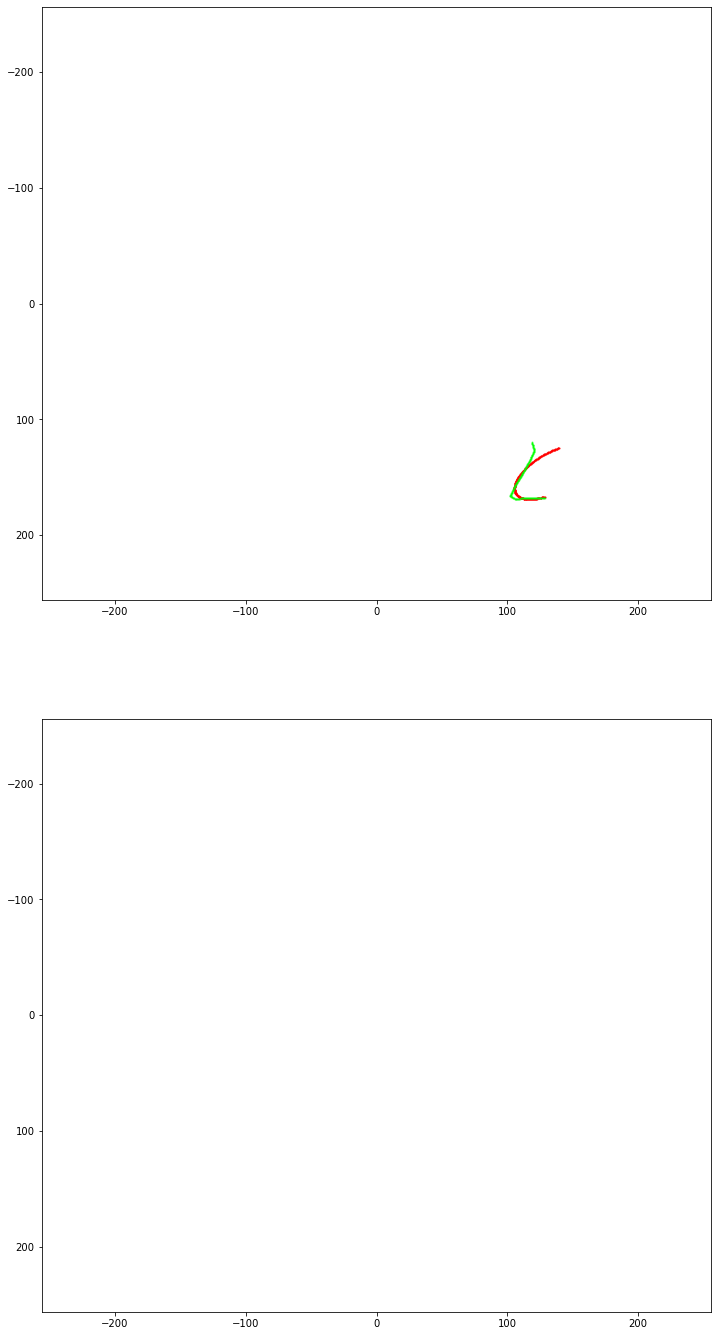

In [41]:
plot_prepared_data(df.iloc[123])

In [39]:
df.iloc[123]

category                                                       face
image_idx                                                       581
part                                                              1
raw                                                   L-shaped nose
processed                                                    l nose
primitive_type                                                    0
M                 [5.482841504351071, -27.998286987536236, 120.0...
error                                                     34.877276
split                                                         train
theta                                                     -1.314449
sx                                                        21.624399
sy                                                       -24.539905
hx                                                        -0.777021
tx                                                       120.002854
ty                                              

### plot GMM

In [ ]:
M_all = np.asarray(df.M.to_list())

0.03401928821265529 151.0491012639971


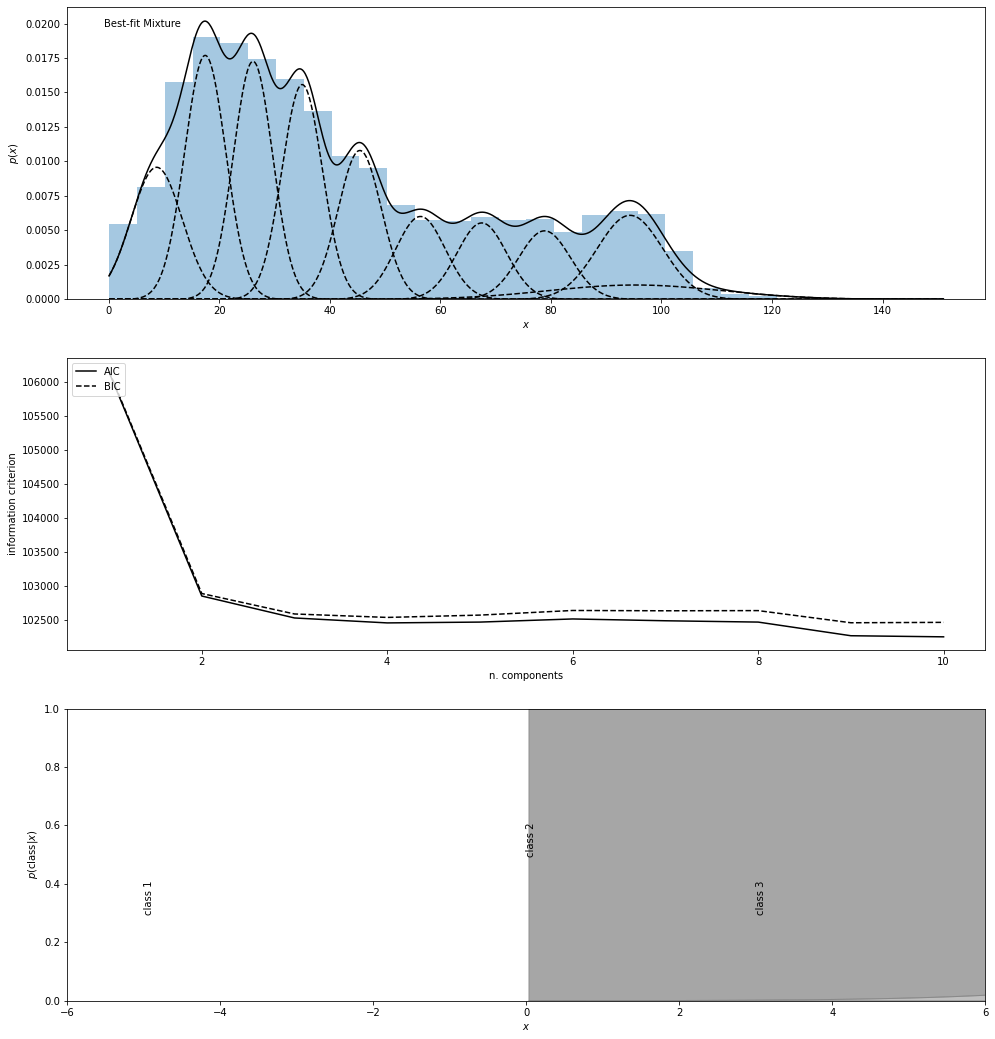

In [44]:
from sklearn.mixture import GaussianMixture

X = np.asarray(df.sx.to_list()).reshape(-1, 1)
# M_all[:,0].reshape(-1, 1)
print(X.min(), X.max())

N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]


#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component

fig = plt.figure(figsize=(15, 20))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig.add_subplot(311)
M_best = models[np.argmin(AIC)]

x = np.linspace(X.min(), X.max(), 1000)
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


# plot 2: AIC and BIC
ax = fig.add_subplot(312)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)


# plot 3: posterior probabilities for each component
ax = fig.add_subplot(313)

p = responsibilities
p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T

ax.fill_between(x, 0, p[0], color='gray', alpha=0.3)
ax.fill_between(x, p[0], p[1], color='gray', alpha=0.5)
ax.fill_between(x, p[1], 1, color='gray', alpha=0.7)
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')

ax.text(-5, 0.3, 'class 1', rotation='vertical')
ax.text(0, 0.5, 'class 2', rotation='vertical')
ax.text(3, 0.3, 'class 3', rotation='vertical')

plt.show()


In [ ]:
print(M_best.weights_)
print(M_best.means_)
print(M_best.covariances_)

### code

In [ ]:
df.iloc[110]

In [ ]:
plot_prepared_data(df.iloc[110])

In [ ]:
drawing_arr = CONST.face_json['train_data']

In [ ]:
reload(rd)
from tqdm import tqdm

M_arr = collections.defaultdict(lambda : np.zeros(9))
M_name = collections.defaultdict(lambda : " ")
M_mse = collections.defaultdict(float)


for idx in tqdm(range(len(drawing_arr))):
# for idx in range(len(drawing_arr)):
#     print(idx)
    
    strokes_spline_fitted = rd.process_quickdraw_to_part_convex_hull(
        drawing_arr[idx],
        list(CONST.face_parts_idx_dict.keys()),
        b_spline_num_sampled_points=n,
    )

    for _, (part_type, sketch_data) in enumerate(strokes_spline_fitted.items()):
        
        mat, prim_name, prim_mse = rd.get_transform_smallest_mse(
            sketch_data, template_dict_processed, use_projective=use_projective,
        )
        M_arr[(idx, part_type)] = mat
        M_name[(idx, part_type)] = prim_name
        M_mse[(idx, part_type)] = prim_mse
        


In [ ]:
with open('/raid/xiaoyuz1/SPG_Face_Part_256_projective_{}_mse.pkl'.format(use_projective), "wb+") as f:
    pickle.dump((dict(M_arr), dict(M_name), dict(M_mse)), f)

In [ ]:
'/raid/xiaoyuz1/SPG_Face_Part_256_projective_{}_mse.pkl'.format(use_projective)

In [ ]:
line_dict = dict(filter(lambda x: x[1] == 'line', M_name.items()))
print(len(line_dict), line_dict)

In [ ]:
M_arr, M_name = None,None
M_mse = None
fname = '/raid/xiaoyuz1/SPG_Face_Part_256_projective_False_mse.pkl'
with open(fname, "rb") as f:
    M_arr, M_name, M_mse = pickle.load(f)

In [ ]:
mse_l = list(filter(lambda x: not math.isinf(x), list(M_mse.values())))
np.mean(mse_l)

In [ ]:
image_list = list(map(lambda x: int(x[0]), M_name.keys()))
stroke_list = list(map(lambda x: int(x[1]), M_name.keys()))
arr_list = list(M_arr.values())
name_list = list(M_name.values())
mse_list = list(M_mse.values())

data = {'image': image_list, 'stroke' : stroke_list, 'M' : arr_list, 'primitive' : name_list, 'mse' : mse_list}

for c_idx,c in enumerate(np.asarray(arr_list).T):
    if c_idx > 5:
        continue
    data['M{}'.format(str(c_idx))] = c

df = pd.DataFrame.from_dict(data)

In [ ]:
dfa = df[df.mse.apply(lambda x: not math.isinf(x))]

In [ ]:
dfa

In [ ]:
M_all = np.asarray(dfa.M.to_list())

---------------------------------------

In [ ]:
idx = 0
stroke_idx = 1

In [ ]:

rd.show_these_sketches(
    CONST.face_json,
    [idx], 
    [str(idx)], 
    [[]], 
    num_pngs_per_row = 6,
    row_figsize = 4,
    column_figsize = 4,
)



In [ ]:
strokes_spline_fitted = rd.process_quickdraw_to_part_convex_hull(
    drawing_arr[idx],
    list(CONST.face_parts_idx_dict.keys()),
    b_spline_num_sampled_points=n,
)

# strokes_spline_fitted = rd.process_quickdraw_to_stroke_no_normalize(
#     drawing_arr[idx], 
#     b_spline_num_sampled_points=200,
# )
# print(len(strokes_spline_fitted))

In [ ]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

parts_indices = list(CONST.face_parts_idx_dict.keys())

drawing_raw = np.asarray(drawing_arr[idx])
drawing_raw[:,0] = np.cumsum(drawing_raw[:,0], 0) + 25
drawing_raw[:,1] = np.cumsum(drawing_raw[:,1], 0) + 25

parts = []
part_idx_part = {}

for k in parts_indices:
    strokes = drawing_raw[drawing_raw[:,-1] == k]
    if len(strokes) < 1:
        continue
    parts.append(strokes)
    part_idx_part[k] = strokes[:,:2]

In [ ]:
M_arr_idx, M_name_idx, M_mse_idx = {},{},{}
for stroke_index, (part_type, data) in enumerate(strokes_spline_fitted.items()):
        
    mat, prim_name, prim_mse = rd.get_transform_smallest_mse(
        data, template_dict_processed, use_projective=use_projective,
    )
    M_arr_idx[(idx, part_type)] = mat
    M_name_idx[(idx, part_type)] = prim_name
    M_mse_idx[(idx, part_type)] = prim_mse

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for k, M in M_arr_idx.items():
#     if k[1] != 3:
#         continue
    data = strokes_spline_fitted[k[1]]
    
    template = template_dict_processed[M_name_idx[(idx, k[1])]]
    Mm = M.reshape(3,3)
    
    result, mse = rd.get_transformed_template(template, data, Mm,projective=use_projective)
    ax1.scatter(result[:,0], result[:,1], label="transformed template", s=1, c='r')
    ax2.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c='g')

# plt.legend()
# plt.xlim(0,w)
# plt.ylim(h,0)


ax1.axis(xmin=0,xmax=w)
ax1.axis(ymin=h,ymax=0)

ax2.axis(xmin=0,xmax=w)
ax2.axis(ymin=h,ymax=0)

plt.show()

In [ ]:
M_arr_idx, M_name_idx, M_mse_idx

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for index, entry in dfa[dfa.image == idx].iterrows():
    data = strokes_spline_fitted[entry.stroke]
    
    template_func = TEMPLATE_DICT[entry.primitive]
    template = template_func(n)
    
    print(entry.M.reshape(3,3))
    
    result, mse = rd.get_transformed_template(template, data, entry.M.reshape(3,3),projective=use_projective)
    ax1.scatter(result[:,0], result[:,1], label="transformed template", s=1, c='r')
    ax2.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c='g')
    orig_data = part_idx_part[int(entry.stroke)]
    ax2.plot(orig_data[:,0], orig_data[:,1], alpha=0.5, c='b')
    
#     ax1.plot(result[:,0], result[:,1], label="transformed template", c='r')
#     ax2.plot(data[:,0], data[:,1], label="data", alpha=0.5,c='g')

# plt.legend()
# plt.xlim(0,w)
# plt.ylim(h,0)

ax1.axis(xmin=0,xmax=w)
ax1.axis(ymin=h,ymax=0)

ax2.axis(xmin=0,xmax=w)
ax2.axis(ymin=h,ymax=0)

plt.show()

## old icp code

In [ ]:
import cv2
import numpy as np
import sys
from numpy.random import *

In [ ]:
def del_miss(indeces, dist, max_dist, th_rate = 0.8):
    th_dist = max_dist * th_rate
    return np.array([indeces[0][np.where(dist.T[0] < th_dist)]])


In [ ]:
def is_converge(Tr, scale):
    delta_angle = 0.0001
    delta_scale = scale * 0.0001
    
    min_cos = 1 - delta_angle
    max_cos = 1 + delta_angle
    min_sin = -delta_angle
    max_sin = delta_angle
    min_move = -delta_scale
    max_move = delta_scale
    
    return min_cos < Tr[0, 0] and Tr[0, 0] < max_cos and \
           min_cos < Tr[1, 1] and Tr[1, 1] < max_cos and \
           min_sin < -Tr[1, 0] and -Tr[1, 0] < max_sin and \
           min_sin < Tr[0, 1] and Tr[0, 1] < max_sin and \
           min_move < Tr[0, 2] and Tr[0, 2] < max_move and \
           min_move < Tr[1, 2] and Tr[1, 2] < max_move

In [ ]:
def icp(d1, d2, max_iterate = 100):
    src = np.array([d1.T], copy=True).astype(np.float32)
    dst = np.array([d2.T], copy=True).astype(np.float32)
    
    knn = cv2.KNearest()
    responses = np.array(range(len(d2[0]))).astype(np.float32)
    knn.train(src[0], responses)
        
    Tr = np.array([[np.cos(0), -np.sin(0), 0],
                   [np.sin(0), np.cos(0),  0],
                   [0,         0,          1]])

    dst = cv2.transform(dst, Tr[0:2])
    max_dist = sys.maxint
    
    scale_x = np.max(d1[0]) - np.min(d1[0])
    scale_y = np.max(d1[1]) - np.min(d1[1])
    scale = max(scale_x, scale_y)
       
    for i in range(max_iterate):
        ret, results, neighbours, dist = knn.find_nearest(dst[0], 1)
        
        indeces = results.astype(np.int32).T     
        indeces = del_miss(indeces, dist, max_dist)  
        
        T = cv2.estimateRigidTransform(dst[0, indeces], src[0, indeces], True)

        max_dist = np.max(dist)
        dst = cv2.transform(dst, T)
        Tr = np.dot(np.vstack((T,[0,0,1])), Tr)
        
        if (is_converge(T, scale)):
            break
        
    return Tr[0:2]

In [ ]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    
    point_count = 100
    th = np.pi / 8
    move = np.array([[0.30], [0.5]])
    rnd_scale = 0.03
    x1 = np.linspace(0, 1.1, point_count)
    y1 = np.sin(x1 * np.pi)
    d1 = np.array([x1, y1])

    rot = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])
    rand = np.random.rand(2, point_count)*rnd_scale
    d2 = np.dot(rot, d1) + move
    d2 = np.add(d2, rand)

    plt.plot(d1[0], d1[1])
    plt.plot(d2[0], d2[1])
    plt.show()

In [ ]:
    ret = icp(d1, d2)
    
    plt.plot(d1[0], d1[1])
    dst = np.array([d2.T], copy=True).astype(np.float32)
    dst = cv2.transform(dst, ret)
    plt.plot(dst[0].T[0], dst[0].T[1])
    plt.show()
    
    print ret[0][0] * ret[0][0] + ret[0][1] * ret[0][1]
    print np.arccos(ret[0][0]) / 2 / np.pi * 360
    print np.arcsin(ret[0][1]) / 2 / np.pi * 360

    print ret

In [ ]:
def icp(a, b,
        max_time = 1
    ):
    import cv2
    import numpy
    import copy
    import pylab
    import time
    import sys
    import sklearn.neighbors
    import scipy.optimize



    def res(p,src,dst):
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        r = numpy.sum(numpy.square(d[:,0])+numpy.square(d[:,1]))
        return r

    def jac(p,src,dst):
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        dUdth_R = numpy.matrix([[-numpy.sin(p[2]),-numpy.cos(p[2])],
                            [ numpy.cos(p[2]),-numpy.sin(p[2])]])
        dUdth = (src*dUdth_R.T).A
        g = numpy.array([  numpy.sum(2*d[:,0]),
                        numpy.sum(2*d[:,1]),
                        numpy.sum(2*(d[:,0]*dUdth[:,0]+d[:,1]*dUdth[:,1])) ])
        return g
    
    def hess(p,src,dst):
        n = numpy.size(src,0)
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        dUdth_R = numpy.matrix([[-numpy.sin(p[2]),-numpy.cos(p[2])],[numpy.cos(p[2]),-numpy.sin(p[2])]])
        dUdth = (src*dUdth_R.T).A
        H = numpy.zeros([3,3])
        H[0,0] = n*2
        H[0,2] = numpy.sum(2*dUdth[:,0])
        H[1,1] = n*2
        H[1,2] = numpy.sum(2*dUdth[:,1])
        H[2,0] = H[0,2]
        H[2,1] = H[1,2]
        d2Ud2th_R = numpy.matrix([[-numpy.cos(p[2]), numpy.sin(p[2])],[-numpy.sin(p[2]),-numpy.cos(p[2])]])
        d2Ud2th = (src*d2Ud2th_R.T).A
        H[2,2] = numpy.sum(2*(numpy.square(dUdth[:,0])+numpy.square(dUdth[:,1]) + d[:,0]*d2Ud2th[:,0]+d[:,0]*d2Ud2th[:,0]))
        return H
    
    
    t0 = time.time()
    init_pose = (0,0,0)
    src = numpy.array([a.T], copy=True).astype(numpy.float32)
    dst = numpy.array([b.T], copy=True).astype(numpy.float32)
    Tr = numpy.array([[numpy.cos(init_pose[2]),-numpy.sin(init_pose[2]),init_pose[0]],
                   [numpy.sin(init_pose[2]), numpy.cos(init_pose[2]),init_pose[1]],
                   [0,                    0,                   1          ]])
    print("src",numpy.shape(src))
    print("Tr[0:2]",numpy.shape(Tr[0:2]))
    src = cv2.transform(src, Tr[0:2])
    p_opt = numpy.array(init_pose)
    T_opt = numpy.array([])
    error_max = sys.maxsize
    first = False
    while not(first and time.time() - t0 > max_time):
        distances, indices = sklearn.neighbors.NearestNeighbors(n_neighbors=1, algorithm='auto',p = 3).fit(dst[0]).kneighbors(src[0])
        p = scipy.optimize.minimize(res,[0,0,0],args=(src[0],dst[0, indices.T][0]),method='Newton-CG',jac=jac,hess=hess).x
        T  = numpy.array([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],[numpy.sin(p[2]), numpy.cos(p[2]),p[1]]])
        p_opt[:2]  = (p_opt[:2]*numpy.matrix(T[:2,:2]).T).A       
        p_opt[0] += p[0]
        p_opt[1] += p[1]
        p_opt[2] += p[2]
        src = cv2.transform(src, T)
        Tr = (numpy.matrix(numpy.vstack((T,[0,0,1])))*numpy.matrix(Tr)).A
        error = res([0,0,0],src[0],dst[0, indices.T][0])

        if error < error_max:
            error_max = error
            first = True
            T_opt = Tr

    p_opt[2] = p_opt[2] % (2*numpy.pi)
    return T_opt, error_max


def main():
    import cv2
    import numpy
    import random
    import matplotlib.pyplot
    n1 = 100
    n2 = 75
    bruit = 1/10
    center = [random.random()*(2-1)*3,random.random()*(2-1)*3]
    radius = random.random()
    deformation = 2

    template = numpy.array([
        [numpy.cos(i*2*numpy.pi/n1)*radius*deformation for i in range(n1)], 
        [numpy.sin(i*2*numpy.pi/n1)*radius for i in range(n1)]
    ])

    data = numpy.array([
        [numpy.cos(i*2*numpy.pi/n2)*radius*(1+random.random()*bruit)+center[0] for i in range(n2)], 
        [numpy.sin(i*2*numpy.pi/n2)*radius*deformation*(1+random.random()*bruit)+center[1] for i in range(n2)]
    ])

    T,error = icp(data,template)
    dx = T[0,2]
    dy = T[1,2]
    rotation = numpy.arcsin(T[0,1]) * 360 / 2 / numpy.pi

    print("T",T)
    print("error",error)
    print("rotation°",rotation)
    print("dx",dx)
    print("dy",dy)

    result = cv2.transform(numpy.array([data.T], copy=True).astype(numpy.float32), T).T
    matplotlib.pyplot.plot(template[0], template[1], label="template")
    matplotlib.pyplot.plot(data[0], data[1], label="data")
    matplotlib.pyplot.plot(result[0], result[1], label="result: "+str(rotation)+"° - "+str([dx,dy]))
    matplotlib.pyplot.legend(loc="upper left")
    matplotlib.pyplot.axis('square')
    matplotlib.pyplot.show()

if __name__ == "__main__":
    main()